In [2]:
import argparse
import pandas as pd
import numpy as np
import mylib.data_preprocessing as dpp

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import load_model

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD
from keras.layers import LeakyReLU

from enum import Enum
import matplotlib.pyplot as plt
from keras.callbacks import Callback
import itertools
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.
/home/thanh_dat/anaconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/thanh_dat/anaconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/thanh_dat/anaconda3/envs/py3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/thanh_da

In [3]:
raw_data = pd.read_csv('train_12.csv', header=0) #train #skeleton_raw
dataset = raw_data.values
X = dataset[:, 0:20].astype(float)
Y = dataset[:, 20]

In [4]:
X_pp = []
for i in range(len(X)):
    X_pp.append(dpp.pose_normalization(X[i]))
X_pp = np.array(X_pp)

In [5]:
print(dpp.pose_normalization(X[0]))
print(X)
print(X_pp)
print(Y)

[0.611111111161111, 0.3333333334793651, 0.3888888888388888, 0.2857142857142857, 0.0, 0.23809523816825398, 0.27777777782777785, 0.0, 0.8888888889888891, 0.3333333334793651, 1.0, 0.6666666667396827, 0.8333333334833333, 0.9047619049079366, 0.44444444464444427, 1.0, 0.7777777779777778, 1.0]
[[0.53703704 0.19565217 0.51851852 ... 0.65217391 0.57407407 0.65217391]
 [0.53703704 0.19565217 0.51851852 ... 0.63043478 0.57407407 0.65217391]
 [0.53703704 0.19565217 0.51851852 ... 0.65217391 0.57407407 0.65217391]
 ...
 [0.53703704 0.13043478 0.51851852 ... 0.67391304 0.57407407 0.67391304]
 [0.53703704 0.15217391 0.51851852 ... 0.67391304 0.57407407 0.65217391]
 [0.53703704 0.13043478 0.51851852 ... 0.65217391 0.57407407 0.65217391]]
[[0.61111111 0.33333333 0.38888889 ... 1.         0.77777778 1.        ]
 [0.61111111 0.33333333 0.38888889 ... 0.95238095 0.77777778 1.        ]
 [0.61111111 0.33333333 0.33333333 ... 1.         0.77777778 1.        ]
 ...
 [0.61538462 0.05555556 0.30769231 ... 1.   

In [6]:
print(X[:,19])

[0.65217391 0.65217391 0.65217391 ... 0.67391304 0.65217391 0.65217391]


In [7]:
encoder = LabelEncoder()
encoder_Y = encoder.fit_transform(Y)
matrix_Y = np_utils.to_categorical(encoder_Y)

In [8]:
print(X_pp.shape)
print(Y.shape)
print(matrix_Y.shape)
print(matrix_Y)

(9600, 18)
(9600,)
(9600, 12)
[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [10]:
print(Y[0], ": ", encoder_Y[0])
print(Y[800], ": ", encoder_Y[800])
print(Y[1600], ": ", encoder_Y[1600])
print(Y[2400], ": ", encoder_Y[2400])
print(Y[3200], ": ", encoder_Y[3200])
print(Y[4000], ": ", encoder_Y[4000])
print(Y[4800], ": ", encoder_Y[4800])
print(Y[5600], ": ", encoder_Y[5600])
print(Y[6400], ": ", encoder_Y[6400])
print(Y[7200], ": ", encoder_Y[7200])
print(Y[8000], ": ", encoder_Y[8000])
print(Y[8800], ": ", encoder_Y[8800])
print(Y[9599], ": ", encoder_Y[9599])

0.0 :  0
1.0 :  1
2.0 :  2
3.0 :  3
4.0 :  4
5.0 :  5
6.0 :  6
7.0 :  7
8.0 :  8
9.0 :  9
10.0 :  10
11.0 :  11
11.0 :  11


In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X_pp, matrix_Y, test_size=0.2, random_state=42)

In [12]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<ipython-input-44-d06dcff44ad8> in <module>
----> 1 his.loss_plot('epoch')

<ipython-input-35-ae441bd5a7b4> in loss_plot(self, loss_type)
     19 
     20     def loss_plot(self, loss_type):
---> 21         iters = range(len(self.losses[loss_type]))
     22         plt.figure()
     23         # acc

AttributeError: 'LossHistory' object has no attribute 'losses'

In [13]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [14]:
his = LossHistory()

In [19]:
model = Sequential()
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(units=12, activation='softmax'))


In [20]:
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=2, validation_data=(X_test, Y_test))

Train on 7680 samples, validate on 1920 samples
Epoch 1/50
 - 1s - loss: 0.0013 - accuracy: 0.9996 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 2/50
 - 0s - loss: 3.4238e-04 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 0.9990
Epoch 3/50
 - 0s - loss: 2.5166e-04 - accuracy: 1.0000 - val_loss: 0.0023 - val_accuracy: 0.9990
Epoch 4/50
 - 0s - loss: 1.8567e-04 - accuracy: 1.0000 - val_loss: 0.0033 - val_accuracy: 0.9990
Epoch 5/50
 - 0s - loss: 2.2160e-04 - accuracy: 1.0000 - val_loss: 0.0029 - val_accuracy: 0.9990
Epoch 6/50
 - 0s - loss: 2.4191e-04 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 0.9990
Epoch 7/50
 - 0s - loss: 3.6364e-04 - accuracy: 0.9999 - val_loss: 0.0031 - val_accuracy: 0.9984
Epoch 8/50
 - 0s - loss: 7.8410e-04 - accuracy: 0.9997 - val_loss: 0.0048 - val_accuracy: 0.9990
Epoch 9/50
 - 0s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0033 - val_accuracy: 0.9990
Epoch 10/50
 - 0s - loss: 3.6824e-04 - accuracy: 0.9999 - val_loss: 0.0012 - val_accura

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               2432      
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_9 (Batch (None, 64)                256       
_________________________________________________________________
dense_12 (Dense)             (None, 12)               

In [37]:
his.loss_plot('epoch')

AttributeError: 'LossHistory' object has no attribute 'losses'

In [38]:
model.save('sign_language_12.h5')

In [40]:
model = load_model('sign_language_12.h5')

In [41]:
Y_pred = model.predict(X_test)

In [42]:
print(X_test)

[[0.5  0.   0.17 ... 1.   0.75 1.  ]
 [0.62 0.   0.23 ... 1.   0.77 0.94]
 [0.44 0.   0.   ... 1.   0.82 0.97]
 ...
 [0.54 0.06 0.15 ... 1.   0.77 1.  ]
 [0.51 0.03 0.18 ... 1.   0.8  0.97]
 [0.46 0.02 0.   ... 0.98 0.86 1.  ]]


In [43]:
print(Y_pred)

[[4.85e-07 1.00e+00 2.92e-06 ... 3.33e-06 2.78e-05 9.13e-07]
 [3.17e-08 3.37e-07 9.43e-08 ... 7.26e-07 2.53e-06 1.00e+00]
 [2.52e-07 6.25e-08 4.40e-08 ... 1.00e+00 2.60e-09 1.18e-08]
 ...
 [2.03e-06 1.53e-06 7.75e-08 ... 2.14e-06 1.96e-06 1.00e+00]
 [2.01e-06 1.04e-07 2.28e-07 ... 9.78e-08 7.11e-07 4.92e-07]
 [2.41e-08 1.59e-08 5.11e-07 ... 1.00e+00 7.16e-09 9.71e-09]]


In [44]:
print(Y_pred.shape)

(1920, 12)


In [45]:
cfm = confusion_matrix(np.argmax(Y_test,axis=1), np.argmax(Y_pred, axis=1))

In [46]:
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 160   0   0   0   0   0   0   0   0   0   0]
 [  0   0 160   0   0   0   0   2   0   0   0   0]
 [  0   0   0 162   0   0   0   0   0   0   0   0]
 [  0   0   0   0 142   0   0   0   0   0   0   0]
 [  0   0   0   0   0 184   0   0   0   0   0   0]
 [  0   0   0   0   0   0 146   0   0   0   0   0]
 [  0   0   0   0   0   0   0 161   0   0   0   0]
 [  0   0   0   0   0   0   0   0 157   0   0   0]
 [  0   0   0   0   0   0   0   0   0 160   0   0]
 [  0   0   0   0   0   0   0   0   0   0 155   0]
 [  0   0   0   0   0   0   0   0   0   0   0 162]]


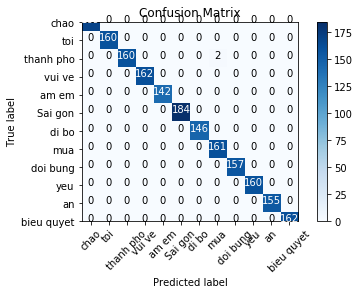

In [47]:
plt.figure()
class_names = ['chao', 'toi', 'thanh pho', 'vui ve', 'am em', 'Sai gon', 'di bo', 'mua', 'doi bung', 'yeu', 'an', 'bieu quyet']
plot_confusion_matrix(cfm, classes=class_names, title='Confusion Matrix')
plt.show()